# Risk Premia in REITs and its application in a quantitative value strategy

##### Dissertation for Master's degree in Economics from [Insper](https://www.insper.edu.br/en/graduate/masters-of-science/)

##### Advisor: [Prof. Dr. Gustavo B. Soares](https://github.com/gustavobsoares/) ([CV](http://lattes.cnpq.br/8491228979459078))
##### Student: Lucas L. Sanches ([Resume](http://lattes.cnpq.br/2528322802099316))

# Miscellaneous Notebook

### Imports

In [1]:
from utils.database import *

In [2]:
from statsmodels.regression.rolling import RollingOLS
from tqdm import tqdm
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline

### Optimal portfolios with international ETFs

In [3]:
start_date = START_DATES['SPBDU1ST Index']
data_ports = data[list(ETFS.values())].copy()
data_ports[['USDJPY Curncy','USDEUR Curncy']] = data_rates[['USDJPY Curncy','USDEUR Curncy']]
data_ports['D5BK B2 Equity'] /= data_ports['USDEUR Curncy']
data_ports['1476 JT Equity'] /= data_ports['USDJPY Curncy']

monthly_data_ports = np.log(data_ports[list(ETFS.values())].resample('M').last()).diff().dropna()
monthly_data_ports['IDUP LN Equity'] -= monthly_data_rates['US0003M Index']
monthly_data_ports['D5BK B2 Equity'] -= monthly_data_rates['EUR003M Equity']
monthly_data_ports['1476 JT Equity'] -= monthly_data_rates['JY0003M Index']
etf_portfolios = monthly_data_ports.loc[monthly_data_ports.index>START_DATES['D5BK B2 Equity']]
print(etf_portfolios.corr())

# statistics of monthly data
placeholders = list(range(len(ETFS.values())))
summary_statistics_etfs = pd.DataFrame({'Obs': placeholders, 'Mean': placeholders, 'Std': placeholders,
                                        'Max': placeholders, 'Min': placeholders}, index=list(ETFS.values()))

for c in list(ETFS.values()):
    aux = monthly_data_ports[c].loc[monthly_data_ports.index>START_DATES[c]]
    obs_ = len(aux)
    mean_ = aux.mean()
    std_ = aux.std()
    max_ = aux.max()
    min_ = aux.min()
    summary_statistics_etfs.loc[c] = [obs_, mean_, std_, max_, min_]
summary_statistics_etfs

                IDUP LN Equity  D5BK B2 Equity  1476 JT Equity
IDUP LN Equity        1.000000        0.838324        0.706482
D5BK B2 Equity        0.838324        1.000000        0.634397
1476 JT Equity        0.706482        0.634397        1.000000


,Obs,Mean,Std,Max,Min
IDUP LN Equity,178,0.003241,0.070481,0.339309,-0.394242
D5BK B2 Equity,44,0.005922,0.076796,0.167056,-0.380028
1476 JT Equity,71,0.007523,0.046359,0.157043,-0.222741


<AxesSubplot:>

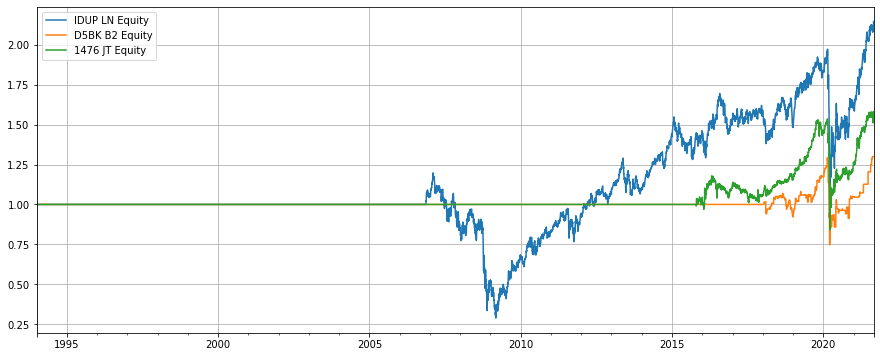

In [4]:
data[summary_statistics_etfs.index].plot(figsize=(15,6),grid=True)

Return                   0.038732
Vol                      0.201209
IDUP LN Equity weight    0.912709
D5BK B2 Equity weight    0.000152
1476 JT Equity weight    0.087138
Name: 8669, dtype: float64

Sharpe = 0.19249752876281082
Var Matrix:                 IDUP LN Equity  D5BK B2 Equity  1476 JT Equity
IDUP LN Equity        0.043685        0.046613        0.024354
D5BK B2 Equity        0.046613        0.070772        0.027836
1476 JT Equity        0.024354        0.027836        0.027203


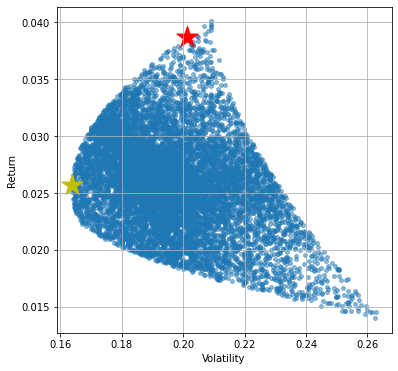

In [5]:
# Using code from https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

port_returns = []
port_vols = []
port_weights = []
num_assets = len(etf_portfolios.columns)
num_portfolios = 10000
asset_returns = np.log(data[list(ETFS.values())].loc[data.index>start_date].resample('Y').last()).diff().dropna().mean()
var_matrix = etf_portfolios.cov() * 12

np.random.seed(42)
for port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    port_weights.append(weights)
    
    returns = np.dot(weights, asset_returns)
    port_returns.append(returns)
    
    var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    port_vols.append(sd)
    
ports = {'Return': port_returns, 'Vol': port_vols}
for i, symbol in enumerate(etf_portfolios.columns.tolist()):
    ports[symbol+' weight'] = [w[i] for w in port_weights]
df_ports = pd.DataFrame(ports)

min_vol_port = df_ports.iloc[df_ports['Vol'].idxmin()]
max_sharpe_port = df_ports.iloc[(df_ports['Return']/df_ports['Vol']).idxmax()]

df_ports.plot.scatter(x='Vol', y='Return', marker='o', s=15, alpha=0.5, grid=True, figsize=(6,6))
plt.scatter(min_vol_port[1], min_vol_port[0], color='y', marker='*', s=500)
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], color='r', marker='*', s=500)
plt.xlabel('Volatility')
plt.ylabel('Return')
print(max_sharpe_port)
print(f'\nSharpe = {max_sharpe_port[0]/max_sharpe_port[1]}')
print(f'Var Matrix: {var_matrix}')

In [6]:
asset_returns

IDUP LN Equity    0.040195
D5BK B2 Equity    0.013801
1476 JT Equity    0.023455
dtype: float64

In [7]:
print('US Sharpe:', 0.040195/np.sqrt(0.043685))
print('Europe Sharpe:', 0.013801/np.sqrt(0.070772))
print('Japan Sharpe:', 0.023455/np.sqrt(0.027203))

US Sharpe: 0.19231176908190553
Europe Sharpe: 0.05187759345796491
Japan Sharpe: 0.14220898493965298


### Optimal portfolios in Brazil

Return                       0.017411
Vol                          0.036368
IBOV Index (ER) weight       0.085138
IFIX Index (ER) weight       0.104272
BZAD10Y Index (ER) weight    0.810590
Name: 1355, dtype: float64

Sharpe = 0.47875952254816484
Var Matrix:                     IBOV Index (ER)  IFIX Index (ER)  BZAD10Y Index (ER)
IBOV Index (ER)            0.062090         0.021168            0.000576
IFIX Index (ER)            0.021168         0.014657            0.000036
BZAD10Y Index (ER)         0.000576         0.000036            0.000383


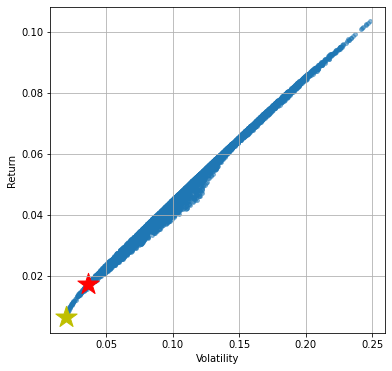

In [8]:
# Using code from https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

start_date = datetime(2015,1,1)
brazil_xs = ['IBOV Index (ER)','IFIX Index (ER)','BZAD10Y Index (ER)']
df_brazil = pd.read_excel('data/data.xlsx', sheet_name='total_return', index_col=0)[brazil_xs].loc[bz_factors.index]
df_brazil = np.log(df_brazil.resample('M').last()).diff().dropna()
all_time_series = df_brazil.loc[df_brazil.index>start_date]

port_returns = []
port_vols = []
port_weights = []
num_assets = len(all_time_series.columns)
num_portfolios = 10000
asset_returns = np.log(data[brazil_xs].loc[data.index>start_date].resample('Y').last()).diff().dropna().mean()
var_matrix = all_time_series.cov() * 12

np.random.seed(42)
for port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    port_weights.append(weights)
    
    returns = np.dot(weights, asset_returns)
    port_returns.append(returns)
    
    var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    port_vols.append(sd)
    
ports = {'Return': port_returns, 'Vol': port_vols}
for i, symbol in enumerate(all_time_series.columns.tolist()):
    ports[symbol+' weight'] = [w[i] for w in port_weights]
df_ports = pd.DataFrame(ports)

min_vol_port = df_ports.iloc[df_ports['Vol'].idxmin()]
max_sharpe_port = df_ports.iloc[(df_ports['Return']/df_ports['Vol']).idxmax()]

df_ports.plot.scatter(x='Vol', y='Return', marker='o', s=15, alpha=0.5, grid=True, figsize=(6,6))
plt.scatter(min_vol_port[1], min_vol_port[0], color='y', marker='*', s=500)
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], color='r', marker='*', s=500)
plt.xlabel('Volatility')
plt.ylabel('Return')
print(max_sharpe_port)
print(f'\nSharpe = {max_sharpe_port[0]/max_sharpe_port[1]}')
print(f'Var Matrix: {var_matrix}')